In [1]:
import torch
DTYPE = torch.float32

import time


🚀 Using device: cuda
✅ FEM completed in 6.0378 seconds


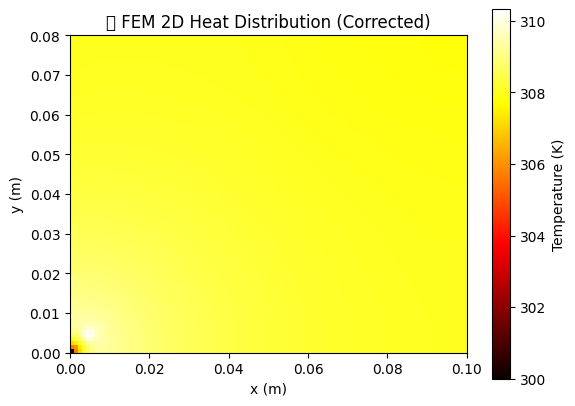

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# Geometry
Lx, Ly = 0.1, 0.08
nx, ny = 100, 80
nnx, nny = nx + 1, ny + 1
dx, dy = Lx / nx, Ly / ny
nn = nnx * nny

# Material and boundary conditions
k = 1.0
h = 0.1
T_inf = 300.0

# Node indexing
def node_id(i, j): return j * nnx + i

# Start timer
start_time = time.time()

# Global stiffness and load
K = torch.zeros((nn, nn), device=device, dtype=DTYPE)
F = torch.zeros((nn,), device=device, dtype=DTYPE)

# Gauss points for 2x2 integration
gauss_pts = [-1/np.sqrt(3), 1/np.sqrt(3)]
weights = [1, 1]

# Shape functions N and gradients dN/dξ, dN/dη
def shape_functions(xi, eta):
    N = torch.tensor([
        0.25*(1 - xi)*(1 - eta),
        0.25*(1 + xi)*(1 - eta),
        0.25*(1 + xi)*(1 + eta),
        0.25*(1 - xi)*(1 + eta),
    ], device=device, dtype=DTYPE)

    dN_dxi = torch.tensor([
        [-0.25*(1 - eta), -0.25*(1 - xi)],
        [ 0.25*(1 - eta), -0.25*(1 + xi)],
        [ 0.25*(1 + eta),  0.25*(1 + xi)],
        [-0.25*(1 + eta),  0.25*(1 - xi)],
    ], device=device, dtype=DTYPE)
    return N, dN_dxi

# Element assembly
for ey in range(ny):
    for ex in range(nx):
        n0 = node_id(ex, ey)
        n1 = node_id(ex+1, ey)
        n2 = node_id(ex+1, ey+1)
        n3 = node_id(ex, ey+1)
        nodes = [n0, n1, n2, n3]

        coords = torch.tensor([
            [ex*dx, ey*dy],
            [(ex+1)*dx, ey*dy],
            [(ex+1)*dx, (ey+1)*dy],
            [ex*dx, (ey+1)*dy],
        ], device=device, dtype=DTYPE)

        Ke = torch.zeros((4, 4), device=device)
        Fe = torch.zeros(4, device=device)

        for i, xi in enumerate(gauss_pts):
            for j, eta in enumerate(gauss_pts):
                N, dN_dxi = shape_functions(xi, eta)

                J = torch.matmul(dN_dxi.T, coords)
                detJ = torch.det(J)
                invJ = torch.inverse(J)
                dN_dx = torch.matmul(dN_dxi, invJ)

                B = dN_dx
                Ke += k * torch.matmul(B, B.T) * detJ * weights[i] * weights[j]

        # Internal heat source (5 W in 4 center elements)
        if 3 <= ex <= 4 and 3 <= ey <= 4:
            Qvol = 5.0 / (4 * dx * dy)
            Fe += Qvol * dx * dy / 4

        # Assemble to global K, F
        for a in range(4):
            A = nodes[a]
            F[A] += Fe[a]
            for b in range(4):
                B_ = nodes[b]
                K[A, B_] += Ke[a, b]

# Convection BC on all 4 edges
for j in range(nny):
    for i in range(nnx):
        nid = node_id(i, j)
        coeff = 0.0
        if i == 0 or i == nx:
            coeff += h * dy / 2
        if j == 0 or j == ny:
            coeff += h * dx / 2
        if coeff > 0:
            K[nid, nid] += coeff
            F[nid] += coeff * T_inf

# Fix one node (Dirichlet anchor)
anchor = node_id(0, 0)
K[anchor, :] = 0
K[anchor, anchor] = 1
F[anchor] = T_inf

# Solve
T = torch.linalg.solve(K, F)
elapsed = time.time() - start_time
print(f"✅ FEM completed in {elapsed:.4f} seconds")

# Plot
T_np = T.detach().cpu().numpy().reshape((nny, nnx))
plt.imshow(T_np, cmap='hot', origin='lower', extent=[0, Lx, 0, Ly])
plt.colorbar(label="Temperature (K)")
plt.title("✅ FEM 2D Heat Distribution (Corrected)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()
